## Dataset

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.dates as mdates

# Load data
df = pd.read_csv('RIB Paper/data/Sunspots.csv')
df['Date'] = pd.to_datetime(df['Date'])
df_filtered = df[(df['Date'] >= '1749-01-01') & (df['Date'] <= '1983-12-31')].reset_index(drop=True)

df_filtered.rename(columns={'Monthly Mean Total Sunspot Number': 'Sunspots'}, inplace=True)
df_filtered = df_filtered[['Date', 'Sunspots']].iloc[:2000]

# Save data to CSV
df_filtered.to_csv('data/Sunspots_clean.csv', index=False)

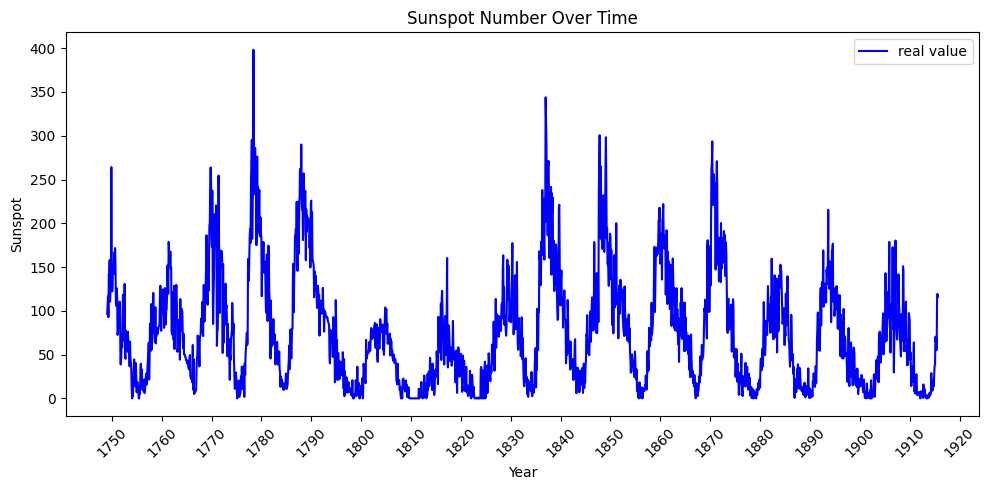

In [11]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Plot data
df = pd.read_csv('data/Sunspots_clean.csv')

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Sunspots'], 'b', label='real value')

# Set x-axis to show major ticks every 10 years
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(10))  # every 10 years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Improve x-axis appearance
plt.xticks(rotation=45)  # Rotate labels for better visibility
plt.xlabel('Year')
plt.ylabel('Sunspot')
plt.title('Sunspot Number Over Time')
plt.legend()
plt.tight_layout()
plt.show()


## AR(1)

In [ ]:
## AR(1) OLS

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import MinMaxScaler

# Load and preprocess data
df = pd.read_csv('data/Sunspots_clean.csv')  
values = df['Sunspots'].values

# Normalize data to [0, 1]
scaler = MinMaxScaler()
scaled_series = scaler.fit_transform(values.reshape(-1, 1)).flatten()

# Split into training and test sets
train = scaled_series[:1000]
test = scaled_series[1000:2000]

print (f"Train size: {len(train)}, Test size: {len(test)}")

# Prepare AR(1) design matrix for training
p = 1  # AR order
T_train = len(train)

# Create lagged input matrix (shape: [T - p, p])
X_train = np.column_stack([train[i:T_train - p + i] for i in range(p)])
y_train = train[p:]

# Solve OLS: phi = (X^T X)^{-1} X^T y
phi_hat = np.linalg.inv(X_train.T @ X_train) @ (X_train.T @ y_train)

print(f"Estimated phi coefficients (AR(1)): {phi_hat.round(4)}")

# 4. Predict on test set
# Start with last p values of training set
prev_vals = list(train[-p:])  
preds = []

for t in range(len(test)):
    x_input = np.array(prev_vals[-p:])  # most recent 1 value
    x_hat = np.dot(phi_hat, x_input)
    preds.append(x_hat)
    prev_vals.append(test[t])  # update with true value (for one-step-ahead)

# 5. Compute MAE and RMSE
mae = np.mean(np.abs(test - preds))
mse = mean_squared_error(test, preds)
rmse = np.sqrt(mse)
print(f"Test MAE (AR(1)): {mae:.4f}") #0.0501
print(f"Test RMSE (AR(1)): {rmse:.4f}") #0.0705

Train size: 1000, Test size: 1000
Estimated phi coefficients (AR(1)): [0.9596]
Test MAE (AR(1)): 0.0501
Test RMSE (AR(1)): 0.0705


In [12]:
## ARMA(1, 0, 0)

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Suppress convergence warnings
warnings.simplefilter('ignore', ConvergenceWarning)

# Load and preprocess data
df = pd.read_csv('data/Sunspots_clean.csv')
values = df['Sunspots'].values

# Normalize data to [0, 1]
scaler = MinMaxScaler()
scaled_series = scaler.fit_transform(values.reshape(-1, 1)).flatten()

# Split into training and test sets
train = scaled_series[:1000]
test = scaled_series[1000:2000]

print (f"Train size: {len(train)}, Test size: {len(test)}")

# Fit AR(1) model using rolling forecast
history = list(train)
preds = []

for t in range(len(test)):
    model = ARIMA(history, order=(1, 0, 0))  # p=1, d=0, q=0
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    preds.append(yhat)
    history.append(test[t])  # Append actual value

# Print estimated coefficients
phi_hat = model_fit.params
print(f"Estimated phi coefficients (ARMA(1, 0, 0)): {phi_hat.round(4)}")

# Evaluate
mae = mean_absolute_error(test, preds)
rmse = np.sqrt(mean_squared_error(test, preds))

print(f"ARMA(1, 0, 0) Model Evaluation:")
print(f"Test MAE: {mae:.4f}") #0.0503
print(f"Test RMSE: {rmse:.4f}") #0.0696

Train size: 1000, Test size: 1000
Estimated phi coefficients (ARMA(1, 0, 0)): [0.1913 0.9054 0.0047]
ARMA(1, 0, 0) Model Evaluation:
Test MAE: 0.0503
Test RMSE: 0.0696


## AR(p)

In [5]:
## AR(6) OLS

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf

# Load and preprocess data
df = pd.read_csv('data/Sunspots_clean.csv')  
values = df['Sunspots'].values

# Normalize data to [0, 1]
scaler = MinMaxScaler()
scaled_series = scaler.fit_transform(values.reshape(-1, 1)).flatten()

# Split into training and test sets
train = scaled_series[:1000]
test = scaled_series[1000:2000]

print (f"Train size: {len(train)}, Test size: {len(test)}")

# Prepare AR(6) design matrix for training
p = 6  # AR order
T_train = len(train)

# Create lagged input matrix (shape: [T - p, p])
X_train = np.column_stack([train[i:T_train - p + i] for i in range(p)])
y_train = train[p:]

# Solve OLS: phi = (X^T X)^{-1} X^T y
phi_hat = np.linalg.inv(X_train.T @ X_train) @ (X_train.T @ y_train)

print(f"Estimated phi coefficients (AR(6)): {phi_hat.round(4)}")

# 4. Predict on test set
# Start with last p values of training set
prev_vals = list(train[-p:])  
preds = []

for t in range(len(test)):
    x_input = np.array(prev_vals[-p:])  # most recent 6 values
    x_hat = np.dot(phi_hat, x_input)
    preds.append(x_hat)
    prev_vals.append(test[t])  # update with true value (for one-step-ahead)

# 5. Compute MAE and RMSE
mae = np.mean(np.abs(test - preds))
mse = mean_squared_error(test, preds)
rmse = np.sqrt(mse)
print(f"Test MAE (AR(6)): {mae:.4f}") #0.0465
print(f"Test RMSE (AR(6)): {rmse:.4f}") #0.0652

Train size: 1000, Test size: 1000
Estimated phi coefficients (AR(6)): [0.0361 0.055  0.1245 0.1148 0.1265 0.526 ]
Test MAE (AR(6)): 0.0465
Test RMSE (AR(6)): 0.0652


In [6]:
## ARMA(6, 0, 0) 

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Suppress convergence warnings
warnings.simplefilter('ignore', ConvergenceWarning)

# Load and preprocess data
df = pd.read_csv('data/Sunspots_clean.csv')
values = df['Sunspots'].values

# Normalize data to [0, 1]
scaler = MinMaxScaler()
scaled_series = scaler.fit_transform(values.reshape(-1, 1)).flatten()

# Split into training and test sets
train = scaled_series[:1000]
test = scaled_series[1000:2000]

# Fit AR(6) model using rolling forecast
history = list(train)
preds = []

for t in range(len(test)):
    model = ARIMA(history, order=(6, 0, 0))  # AR(6), d=0, q=0
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    preds.append(yhat)
    history.append(test[t])  # Append actual value

# Print estimated coefficients
phi_hat = model_fit.params
print(f"Estimated phi coefficients (ARMA(6, 0, 0)): {phi_hat.round(4)}")

# Evaluate
mae = mean_absolute_error(test, preds)
rmse = np.sqrt(mean_squared_error(test, preds))

print(f"ARMA(6, 0, 0) Model Evaluation:")
print(f"Test MAE: {mae:.4f}") #0.0468
print(f"Test RMSE: {rmse:.4f}") #0.0650

# 3mins

Estimated phi coefficients (ARMA(6, 0, 0)): [0.1933 0.5416 0.1374 0.0712 0.087  0.0557 0.0673 0.004 ]
ARMA(6, 0, 0) Model Evaluation:
Test MAE: 0.0468
Test RMSE: 0.0650


<Figure size 1200x500 with 0 Axes>

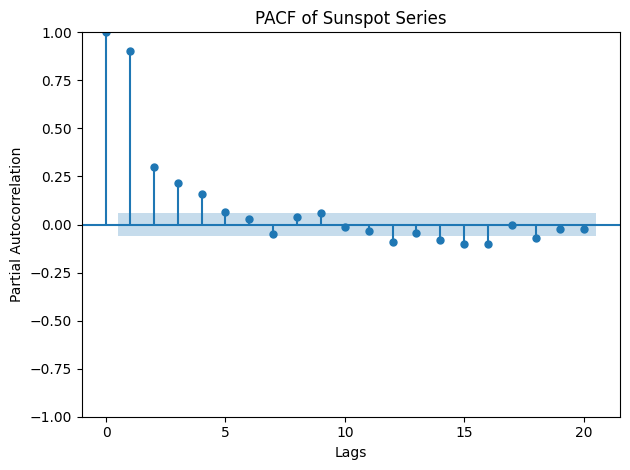

In [4]:
# Plot PACF of the series
plt.figure(figsize=(12, 5))
plot_pacf(train, lags=20, method='ywm')
plt.title('PACF of Sunspot Series')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.tight_layout()
plt.show()

## ARMA(p,q)

In [ ]:
## ARMA(6, 0, 1) 

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Suppress convergence warnings
warnings.simplefilter('ignore', ConvergenceWarning)

# Load and preprocess data
df = pd.read_csv('data/Sunspots_clean.csv')
values = df['Sunspots'].values

# Normalize data to [0, 1]
scaler = MinMaxScaler()
scaled_series = scaler.fit_transform(values.reshape(-1, 1)).flatten()

# Split into training and test sets
train = scaled_series[:1000]
test = scaled_series[1000:2000]

print (f"Train size: {len(train)}, Test size: {len(test)}")

# Fit ARMA(6, 0, 1) model using rolling forecast
history = list(train)
preds = []

for t in range(len(test)):
    model = ARIMA(history, order=(6, 0, 1))  # p=6, d=0, q=1
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    preds.append(yhat)
    history.append(test[t])  # Append actual value

# Print estimated coefficients
phi_hat = model_fit.params
print(f"Estimated phi coefficients (ARMA(6, 0, 1)): {phi_hat.round(4)}")

# Evaluate
mae = mean_absolute_error(test, preds)
rmse = np.sqrt(mean_squared_error(test, preds))

print(f"ARMA(6, 0, 1) Model Evaluation:")
print(f"Test MAE: {mae:.4f}") #0.0468
print(f"Test RMSE: {rmse:.4f}") #0.0651

# 3mins

ARMA(6, 0, 1) Model Evaluation:
Test MAE: 0.0468
Test RMSE: 0.0651


<Figure size 1200x500 with 0 Axes>

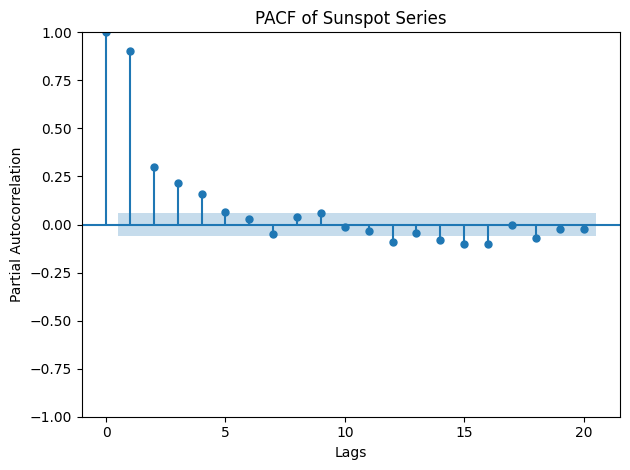

<Figure size 1200x500 with 0 Axes>

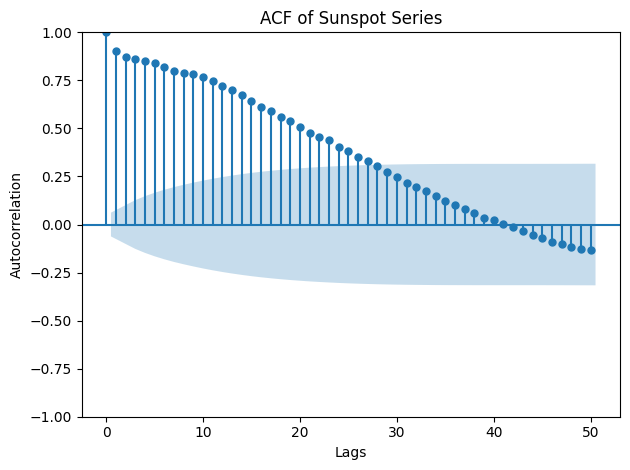

In [ ]:
# Plot PACF of the series
plt.figure(figsize=(12, 5))
plot_pacf(train, lags=20)
plt.title('PACF of Sunspot Series')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.tight_layout()
plt.show()

# plot ACF
plt.figure(figsize=(12, 5))
plot_acf(train, lags=50)
plt.title('ACF of Sunspot Series')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.tight_layout()
plt.show()

## LSTM

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_absolute_error

# Load and normalize the data
df = pd.read_csv('data/Sunspots_clean.csv')
series = df['Sunspots'].dropna().values

# Scale to [0, 1]
scaler = MinMaxScaler()
scaled_series = scaler.fit_transform(series.reshape(-1, 1)).flatten()

# 2. Sequence preparation for LSTM
class TimeSeriesDataset(Dataset):
    def __init__(self, data, n_lags):
        self.n_lags = n_lags
        self.data = data

    def __len__(self):
        return len(self.data) - self.n_lags

    def __getitem__(self, i):
        x = self.data[i:i+self.n_lags]
        y = self.data[i+self.n_lags]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Train-test split and DataLoader setup
n_lags = 16
train_data = scaled_series[:1000]
test_data = scaled_series[1000 - n_lags:2000]

train_dataset = TimeSeriesDataset(train_data, n_lags)
test_dataset = TimeSeriesDataset(test_data, n_lags)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = x.unsqueeze(-1)
        out, _ = self.lstm(x)
        out = self.linear(out[:, -1])
        return out.squeeze()

# Training 
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.train()
for epoch in range(100):
    total_loss = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        preds = model(x_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.6f}")

Epoch 10, Loss: 0.004609
Epoch 20, Loss: 0.004201
Epoch 30, Loss: 0.003987
Epoch 40, Loss: 0.003877
Epoch 50, Loss: 0.003826
Epoch 60, Loss: 0.003833
Epoch 70, Loss: 0.003713
Epoch 80, Loss: 0.003635
Epoch 90, Loss: 0.003651
Epoch 100, Loss: 0.003643


In [ ]:
# Evaluation
model.eval()
preds = []
trues = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        pred = model(x_batch)
        preds.append(pred.item())
        trues.append(y_batch.item())

# Compute error MAE and RMSE
mae = mean_absolute_error(trues, preds)
rmse = sqrt(mean_squared_error(trues, preds))

print(f"LSTM Test MAE : {mae:.4f}") # 0.0455
print(f"LSTM Test RMSE: {rmse:.4f}") # 0.0635

LSTM Test MAE : 0.0455
LSTM Test RMSE: 0.0635


## RIB-LSTM

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import norm

# load data
df = pd.read_csv('data/Sunspots_clean.csv')

# Convert to numpy array and reshape for scaling
values = df['Sunspots'].values.reshape(-1, 1)

scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(values).flatten()

# split the data into train and test sets
train_seq = scaled_values[:1000]
test_seq = scaled_values[1000:2000]

# Ensure the sequences are of the same length
X_train = torch.tensor(train_seq[:-1]).unsqueeze(0).float()  
Y_train = torch.tensor(train_seq[1:]).unsqueeze(0).float()   

X_val = torch.tensor(test_seq[:-1]).unsqueeze(0).float()
Y_val = torch.tensor(test_seq[1:]).unsqueeze(0).float()

print(f"Train X: {X_train.shape}, Train Y: {Y_train.shape}")
print(f"Val X: {X_val.shape}, Val Y: {Y_val.shape}")

# Create DataLoader for training and validation sets
train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=1, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, Y_val), batch_size=1, shuffle=False)

Train X: torch.Size([1, 999]), Train Y: torch.Size([1, 999])
Val X: torch.Size([1, 999]), Val Y: torch.Size([1, 999])


In [ ]:
# Step 1 : Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim + hidden_dim, 16),
            nn.ReLU(),
            nn.Linear(16, z_dim * 2)  
        )

    def forward(self, x_t, h_prev):
        inp = torch.cat([x_t, h_prev], dim=-1)
        stats = self.fc(inp)
        mu, logvar = stats.chunk(2, dim=-1)
        return mu, logvar

# Step 2 : Prior
class Prior(nn.Module):
    def __init__(self, hidden_dim, z_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 16),
            nn.ReLU(),
            nn.Linear(16, z_dim * 2)
        )

    def forward(self, h_prev):
        stats = self.fc(h_prev)
        mu, logvar = stats.chunk(2, dim=-1)
        return mu, logvar

# Step 3 : Decoder
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(z_dim + hidden_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 2)  
        )

    def forward(self, z_t, h_prev):
        inp = torch.cat([z_t, h_prev], dim=-1)
        stats = self.fc(inp)
        mu, logvar = stats.chunk(2, dim=-1)
        return mu, logvar

# Reparameterization trick
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

# Step 4 : VIB_LSTM_Model
class VIB_LSTM_Model(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, z_dim=16):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.z_dim = z_dim

        self.encoder = Encoder(input_dim, hidden_dim, z_dim)
        self.prior = Prior(hidden_dim, z_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        # Use LSTMCell 
        self.lstm_cell = nn.LSTMCell(z_dim, hidden_dim)

    def forward(self, x_t, h_prev, c_prev):
        # Encoder
        mu_enc, logvar_enc = self.encoder(x_t, h_prev)
        z_t = reparameterize(mu_enc, logvar_enc)

        # Prior
        mu_prior, logvar_prior = self.prior(h_prev)

        # Decoder
        mu_dec, logvar_dec = self.decoder(z_t, h_prev)

        # Single LSTM step
        h_t, c_t = self.lstm_cell(z_t, (h_prev, c_prev))

        return {
            'z_t': z_t,
            'mu_enc': mu_enc, 'logvar_enc': logvar_enc,
            'mu_prior': mu_prior, 'logvar_prior': logvar_prior,
            'mu_dec': mu_dec, 'logvar_dec': logvar_dec,
            'h_t': h_t, 'c_t': c_t  
        }

# Loss function
LOG_2PI = torch.tensor(np.log(2.0 * np.pi))

def rib_loss(outputs, y_t, beta=0.005):
    
    mu_enc = outputs['mu_enc']
    logvar_enc = outputs['logvar_enc']
    mu_prior = outputs['mu_prior']
    logvar_prior = outputs['logvar_prior']
    mu_dec = outputs['mu_dec']
    logvar_dec = outputs['logvar_dec']

    log_2pi = LOG_2PI.to(y_t.device) 

    # Decoder Gaussian NLL
    var_dec = logvar_dec.exp()
    nll = 0.5 * (log_2pi + logvar_dec + ((y_t - mu_dec) ** 2) / var_dec)
    recon_loss = nll.mean()

    # KL(q || p)
    var_enc = logvar_enc.exp()
    var_prior = logvar_prior.exp()
    kl = 0.5 * torch.sum(logvar_prior - logvar_enc + (var_enc + (mu_enc - mu_prior) ** 2) / var_prior - 1, dim=-1).mean()

    return recon_loss + beta * kl

In [28]:
# Initialize model
model = VIB_LSTM_Model(input_dim=1, hidden_dim=64, z_dim=16)
optimizer = optim.Adam(model.parameters(), lr=0.001)
beta = 0.005
num_epochs = 1000

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for X_batch, Y_batch in train_loader:
        h_t = torch.zeros(X_batch.size(0), model.hidden_dim)
        c_t = torch.zeros(X_batch.size(0), model.hidden_dim)

        loss = 0.0
        for t in range(X_batch.size(1)):
            x_t = X_batch[:, t].unsqueeze(-1)
            y_t = Y_batch[:, t].unsqueeze(-1)

            out = model(x_t, h_t, c_t)
            h_t = out['h_t']
            c_t = out['c_t']

            loss += rib_loss(out, y_t, beta=beta) 

        loss /= X_batch.size(1) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    if (epoch + 1) % 100 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_loss:.4f}")

# 5mins

Epoch 1/1000 | Train Loss: 1.0350
Epoch 100/1000 | Train Loss: -0.4030
Epoch 200/1000 | Train Loss: -0.4356
Epoch 300/1000 | Train Loss: -0.4693
Epoch 400/1000 | Train Loss: -1.0653
Epoch 500/1000 | Train Loss: -1.4252
Epoch 600/1000 | Train Loss: -1.3074
Epoch 700/1000 | Train Loss: -1.5336
Epoch 800/1000 | Train Loss: -1.5633
Epoch 900/1000 | Train Loss: -1.3638
Epoch 1000/1000 | Train Loss: -1.5717


In [36]:
# Evaluation
model.eval()

preds = []
trues = []
vars_all = []

with torch.no_grad():
    for X_batch, Y_batch in val_loader:
        h_t = torch.zeros(X_batch.size(0), model.hidden_dim)
        c_t = torch.zeros(X_batch.size(0), model.hidden_dim)

        pred_mu = []
        pred_var = []

        for t in range(X_batch.size(1)):
            x_t = X_batch[:, t].unsqueeze(-1)
            y_t = Y_batch[:, t].unsqueeze(-1)

            out = model(x_t, h_t, c_t)
            h_t = out['h_t']
            c_t = out['c_t']

            mu_dec = out['mu_dec']
            logvar_dec = out['logvar_dec']

            pred_mu.append(mu_dec.squeeze(-1))
            pred_var.append(torch.exp(logvar_dec).squeeze(-1))

        pred_mu = torch.stack(pred_mu, dim=1)  # [1, T]
        pred_var = torch.stack(pred_var, dim=1)  # [1, T]

        preds.append(pred_mu)
        vars_all.append(pred_var)
        trues.append(Y_batch)

# concat single batch
preds = torch.cat(preds, dim=0).squeeze(0).numpy()  # [T]
trues = torch.cat(trues, dim=0).squeeze(0).numpy()
vars_all = torch.cat(vars_all, dim=0).squeeze(0).numpy()

# Calculate MAE, RMSE
mae = np.mean(np.abs(preds - trues))
rmse = np.sqrt(np.mean((preds - trues)**2))

print(f"RIB-LSTM MAE: {mae:.4f} | RMSE: {rmse:.4f}") # MAE : 0.0458 | RMSE : 0.0644

RIB-LSTM MAE: 0.0466 | RMSE: 0.0643


### RIB-VLSTM

In [37]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import norm

# load data
df = pd.read_csv('data/Sunspots_clean.csv')

# Convert to numpy array and reshape for scaling
values = df['Sunspots'].values.reshape(-1, 1)

scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(values).flatten()

# split the data into train and test sets
train_seq = scaled_values[:1000]
test_seq = scaled_values[1000:2000]

# Ensure the sequences are of the same length
X_train = torch.tensor(train_seq[:-1]).unsqueeze(0).float()
Y_train = torch.tensor(train_seq[1:]).unsqueeze(0).float()

X_val = torch.tensor(test_seq[:-1]).unsqueeze(0).float()
Y_val = torch.tensor(test_seq[1:]).unsqueeze(0).float()

print(f"Train X: {X_train.shape}, Train Y: {Y_train.shape}")
print(f"Val X: {X_val.shape}, Val Y: {Y_val.shape}")

# Create DataLoader for training and validation sets
train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=1, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, Y_val), batch_size=1, shuffle=False)

Train X: torch.Size([1, 999]), Train Y: torch.Size([1, 999])
Val X: torch.Size([1, 999]), Val Y: torch.Size([1, 999])


In [ ]:
# Step 1 : Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim + hidden_dim, 16),
            nn.ReLU(),
            nn.Linear(16, z_dim * 2)  
        )

    def forward(self, x_t, h_prev):
        inp = torch.cat([x_t, h_prev], dim=-1)
        stats = self.fc(inp)
        mu, logvar = stats.chunk(2, dim=-1)
        return mu, logvar

# Step 2 : Prior
class Prior(nn.Module):
    def __init__(self, hidden_dim, z_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 16),
            nn.ReLU(),
            nn.Linear(16, z_dim * 2)
        )

    def forward(self, h_prev):
        stats = self.fc(h_prev)
        mu, logvar = stats.chunk(2, dim=-1)
        return mu, logvar

# Step 3 : Decoder
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(z_dim + hidden_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 2)  
        )

    def forward(self, z_t, h_prev):
        inp = torch.cat([z_t, h_prev], dim=-1)
        stats = self.fc(inp)
        mu, logvar = stats.chunk(2, dim=-1)
        return mu, logvar

# Reparameterization trick
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

# Step 4 : RIB_VLSTM_Model
class RIB_VLSTM_Model(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, z_dim=16):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.z_dim = z_dim

        self.encoder = Encoder(input_dim, hidden_dim, z_dim)
        self.prior = Prior(hidden_dim, z_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        # Output gate:
        self.output_gate = nn.Linear(hidden_dim + input_dim, hidden_dim)
        self.z_to_hidden = nn.Linear(z_dim, hidden_dim)  

    def forward(self, x_t, h_prev):
        mu_enc, logvar_enc = self.encoder(x_t, h_prev)
        z_t = reparameterize(mu_enc, logvar_enc)

        mu_prior, logvar_prior = self.prior(h_prev)
        mu_dec, logvar_dec = self.decoder(z_t, h_prev)

        # Output gate: o_t = σ(Wo [h_prev, x_t])
        o_t = torch.sigmoid(self.output_gate(torch.cat([h_prev, x_t], dim=-1)))

        # Project z to hidden dim for tanh
        z_proj = self.z_to_hidden(z_t)

        h_t = o_t * torch.tanh(z_proj)

        return {
            'z_t': z_t,
            'mu_enc': mu_enc, 'logvar_enc': logvar_enc,
            'mu_prior': mu_prior, 'logvar_prior': logvar_prior,
            'mu_dec': mu_dec, 'logvar_dec': logvar_dec,
            'h_t': h_t
        }

# Loss function
LOG_2PI = torch.tensor(np.log(2.0 * np.pi))

def rib_loss(outputs, y_t, beta=0.005):
    
    mu_enc = outputs['mu_enc']
    logvar_enc = outputs['logvar_enc']
    mu_prior = outputs['mu_prior']
    logvar_prior = outputs['logvar_prior']
    mu_dec = outputs['mu_dec']
    logvar_dec = outputs['logvar_dec']

    log_2pi = LOG_2PI.to(y_t.device) 

    # Decoder Gaussian NLL
    var_dec = logvar_dec.exp()
    nll = 0.5 * (log_2pi + logvar_dec + ((y_t - mu_dec) ** 2) / var_dec)
    recon_loss = nll.mean()

    # KL(q || p)
    var_enc = logvar_enc.exp()
    var_prior = logvar_prior.exp()
    kl = 0.5 * torch.sum(logvar_prior - logvar_enc + (var_enc + (mu_enc - mu_prior) ** 2) / var_prior - 1, dim=-1).mean()

    return recon_loss + beta * kl

In [400]:
model = RIB_VLSTM_Model(input_dim=1, hidden_dim=64, z_dim=16)
optimizer = optim.Adam(model.parameters(), lr=0.002)
beta = 0.005
num_epochs = 1500

# For numerical stability, put on device
LOG_2PI = torch.log(torch.tensor(2.0 * np.pi)).to(next(model.parameters()).device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for X_batch, Y_batch in train_loader:
        # Init hidden state
        h_t = torch.zeros(X_batch.size(0), model.hidden_dim)

        # Move to device if needed
        h_t = h_t.to(X_batch.device)

        loss = 0.0
        for t in range(X_batch.size(1)):
            x_t = X_batch[:, t].unsqueeze(-1)
            y_t = Y_batch[:, t].unsqueeze(-1)

            out = model(x_t, h_t)
            h_t = out['h_t']

            mu_dec = out['mu_dec'].squeeze(-1)
            logvar_dec = out['logvar_dec'].squeeze(-1)

            loss += rib_loss(out, y_t, beta=beta) 

        loss /= X_batch.size(1) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    if (epoch + 1) % 100 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_loss:.4f}")

# 4mins

Epoch 1/1500 | Train Loss: 1.0130
Epoch 100/1500 | Train Loss: -0.4971
Epoch 200/1500 | Train Loss: -1.2827
Epoch 300/1500 | Train Loss: -0.8965
Epoch 400/1500 | Train Loss: -1.4811
Epoch 500/1500 | Train Loss: -1.4277
Epoch 600/1500 | Train Loss: -1.4963
Epoch 700/1500 | Train Loss: -1.5012
Epoch 800/1500 | Train Loss: -1.5039
Epoch 900/1500 | Train Loss: -1.5066
Epoch 1000/1500 | Train Loss: -1.5110
Epoch 1100/1500 | Train Loss: -1.5046
Epoch 1200/1500 | Train Loss: -1.5120
Epoch 1300/1500 | Train Loss: -1.4863
Epoch 1400/1500 | Train Loss: -1.5169
Epoch 1500/1500 | Train Loss: -1.5141


In [ ]:
# Evaluation for RIB-VLSTM
model.eval()

preds = []
trues = []
vars_all = []
with torch.no_grad():
    for X_batch, Y_batch in val_loader:
        h_t = torch.zeros(X_batch.size(0), model.hidden_dim)

        pred_mu = []
        pred_var = []

        for t in range(X_batch.size(1)):
            x_t = X_batch[:, t].unsqueeze(-1)
            y_t = Y_batch[:, t].unsqueeze(-1)

            out = model(x_t, h_t)
            h_t = out['h_t']

            mu_dec = out['mu_dec']
            logvar_dec = out['logvar_dec']

            pred_mu.append(mu_dec.squeeze(-1))
            pred_var.append(torch.exp(logvar_dec).squeeze(-1))

        pred_mu = torch.stack(pred_mu, dim=1)  # [batch, T]
        pred_var = torch.stack(pred_var, dim=1)

        preds.append(pred_mu)
        vars_all.append(pred_var)
        trues.append(Y_batch)

# Concatenate all batches
preds = torch.cat(preds, dim=0).numpy()
trues = torch.cat(trues, dim=0).numpy()
vars_all = torch.cat(vars_all, dim=0).numpy()

# Calculate metrics
mae = np.mean(np.abs(preds - trues))
rmse = np.sqrt(np.mean((preds - trues) ** 2))

print(f" RIB-VLSTM MAE: {mae:.4f} | RMSE: {rmse:.4f}") # MAE : 0.0469 | RMSE : 0.0655

 RIB-VLSTM MAE: 0.0469 | RMSE: 0.0655
